#### animating the scoring logic as a function of elevator height and arm angle
#### 20250203 CJH

In [375]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, clear_output
import time

#### setting up the plot - lots of matplotlib

In [297]:
# set up the plot
# Define plot limits
x_limits = (-20, 40)
y_limits = (0, 90)

# Define static elements of the target structure
target_structure = {
    "base": {"type": "rectangle", "xy": (18, 0), "width": 19.2, "height": 17.8, "color": "gray"},
    "vertical_pipe": {"type": "line", "start": (30.2, 17.9), "end": (30.2, 53.8), "color": "purple"},
    "connector": {"type": "line", "start": (30.2, 53.8), "end": (19.8, 64.6), "color": "purple"},
    "L2": {"type": "line", "start": (30.2, 24.2), "end": (20, 31.2), "color": "purple"},
    "L3": {"type": "line", "start": (29.9, 40.1), "end": (20, 47.1), "color": "purple"},
    "L4": {"type": "line", "start": (19.8, 64.6), "end": (19.8, 71.9), "color": "purple"},
}

# Define the dynamic robot arm parameters
L = 20.5  # Arm length in inches
pivot_size = 6  # Size of pivot point box
arm_color = "blue"
end_effector_color = "red"
gamepiece_size = (12, 4)  # Gamepiece dimensions (length, width)
gamepiece_color = "red"

#Plot options
fontsize = 8

# Engagement points
engagement_positions =  {'H1': {'H': 17.87, 'THETA': 15.0},
                         'H2': {'H': 19.27, 'THETA': 45.74},
                         'H3': {'H': 35.17, 'THETA': 45.74},
                         'H4': {'H': 59.64, 'THETA': 46.69}}

# in case we want to switch angle definition 
def convert_theta(theta):
    """Convert the angle from the new convention (0° = up, CW positive) to the previous convention."""
    # return theta + 90  # just pass through standard math convention - 0 to the right and CCW positive 
    return theta 
    # return -(theta - 180)


#### defining plots and animations

In [379]:

def draw_robot(ax, H, THETA, time=0, static=False):
    """Draw the robot arm and gamepiece given H (height) and THETA (angle from vertical)."""
    THETA = convert_theta(THETA)  # Convert theta to the correct convention
    ax.clear()
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_aspect("equal")
    ax.set_title(f"robot arm placement at t={time:.2f}s", fontsize=fontsize)
    
    # Draw static target structure
    for name, part in target_structure.items():
        if part["type"] == "rectangle":
            ax.add_patch(patches.Rectangle(part["xy"], part["width"], part["height"], color=part["color"], alpha=0.5))
        elif part["type"] == "line":
            ax.plot([part["start"][0], part["end"][0]], [part["start"][1], part["end"][1]], color=part["color"], linewidth=2)
            ax.plot(part["start"][0], part["start"][1], 'ko', markersize=2, fillstyle='none')  # Open circle at start
            ax.plot(part["end"][0], part["end"][1], 'ko', markersize=2, fillstyle='none')  # Open circle at end

    
    # Draw elevator (black vertical line from (0,0) to (0,H))
    ax.plot([0, 0], [0, H], color="black", linewidth=2)
    
    # Draw pivot point
    ax.add_patch(patches.Rectangle((-pivot_size/2, H - pivot_size/2), pivot_size, pivot_size, edgecolor="black", facecolor="none", linewidth=2))
    ax.plot(0, H, "bo", markersize=6)  # Pivot point in blue
    
    # Compute arm endpoint
    arm_x = L * np.cos(np.radians(THETA))
    arm_y = H + L * np.sin(np.radians(THETA))
    ax.plot([0, arm_x], [H, arm_y], color=arm_color, linewidth=2)
    ax.plot(arm_x, arm_y, "bo", markersize=3)  # End effector in blue
    
    # Compute gamepiece rectangle center at end of the arm + 2 inches along the arm direction
    gamepiece_center_x = arm_x + (gamepiece_size[1] / 2)  * np.cos(np.radians(THETA))
    gamepiece_center_y = arm_y + (gamepiece_size[1] / 2)  * np.sin(np.radians(THETA))
    ax.plot(gamepiece_center_x, gamepiece_center_y, "go", markersize=3)  # Coral center in green

    # getting the corner of the box is a pain
    coral_corner = (gamepiece_center_x + (gamepiece_size[0] / 2) * np.sin(np.radians(THETA)) + (gamepiece_size[1] / 2)  * np.cos(np.radians(THETA)),
                   gamepiece_center_y - (gamepiece_size[0] / 2) * np.cos(np.radians(THETA)) + (gamepiece_size[1] / 2)  * np.sin(np.radians(THETA)))
    # ax.plot(*coral_corner, "yo", markersize=3)  # Coral corner in yellow
    
    gamepiece_rect = patches.Rectangle(
        xy=coral_corner,
        width=gamepiece_size[0],
        height=gamepiece_size[1],
        angle=THETA+90,
        edgecolor=gamepiece_color,
        facecolor="none",
        linewidth=2
    )
    ax.add_patch(gamepiece_rect)
    
    # Annotate time
    ax.text(-15, 85, f"time: {time:.2f}s  h:{H:.1f}  theta:{THETA:2.1f}", fontsize=fontsize, bbox=dict(facecolor='white', edgecolor='black'))
    if static:
        return ax
    else:
        plt.draw()

def animate_trajectory(trajectory):
    """Animate a given trajectory dictionary with keys: time, H, THETA in Jupyter Notebook."""
    fig, ax = plt.subplots(figsize=(6, 6))
    for t, H, THETA in zip(trajectory["time"], trajectory["H"], trajectory["THETA"]):
        draw_robot(ax, H, THETA, t)
        display(fig)  # Explicitly display the updated figure
        clear_output(wait=True)  # Clear the previous frame
        time.sleep(0.01)  # Ensure smooth frame update
    
    plt.show()  # Show final frame


#### using the plots

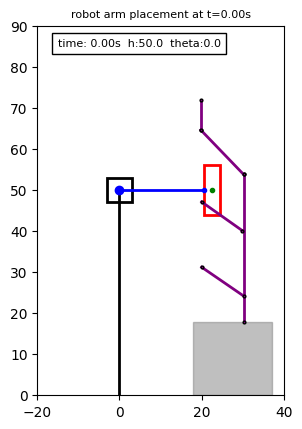

In [363]:
# Example usage: Draw static arm at H, THETA
draw_robot(plt.gca(), 50, 0)

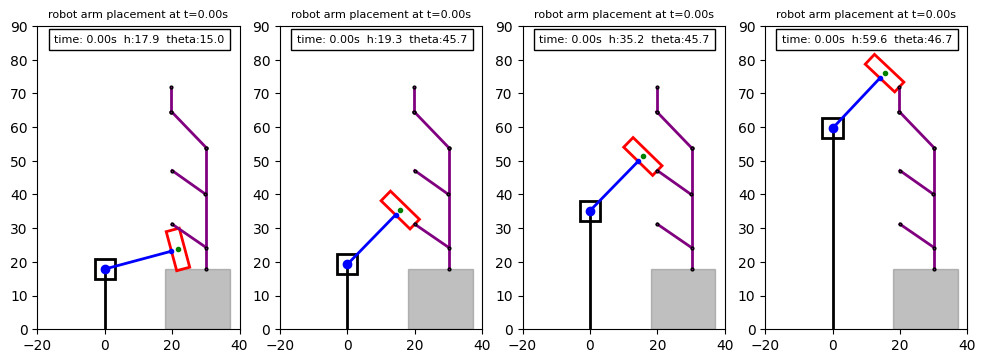

In [364]:
fig, axs = plt.subplots(1, 4, figsize=(12, 10))  # Create a 2x2 grid of subplots
ax_flat = axs.flatten()  # Flatten the 2D array of axes into a list
for ix, (key, value) in enumerate(engagement_positions.items()):
    draw_robot(ax_flat[ix], **value, static=True)  # Pass the specific subplot axis
plt.show()  

#### how to solve for the optimal starting point for each target - probably does not care about angle of target

In [365]:
# solve for the engagement positions
from scipy.optimize import least_squares

# Define arm length and gamepiece size
L = 20.5  # Arm length in inches
gamepiece_size = (12, 4)  # Gamepiece dimensions (length, width)

# Define target heights and x-coordinates
target_pipes = {
    "H1": {"height": 17.9, "x": 24},
    "H2": {"height": 31.2, "x": 20},
    "H3": {"height": 47.1, "x": 20},
    "H4": {"height": 71.9, "x": 19.8},
}

def solve_engagement(H_target, x_target):
    """Solve for H and THETA given the bottom center of the gamepiece must align with (x_target, H_target)."""
    def equations(vars):
        H, theta = vars
        theta = np.radians(theta)

        # Compute arm endpoint
        arm_x = L * np.cos(theta)
        arm_y = H + L * np.sin(theta)

        # Compute gamepiece center (2 inches along the arm direction)
        gamepiece_x = arm_x + 2 * np.cos(theta)
        gamepiece_y = arm_y + 2 * np.sin(theta)

        # Compute bottom center of the gamepiece (6 inches perpendicular to the arm direction)
        bottom_x = gamepiece_x  + 6 * np.cos(theta - np.radians(90))
        bottom_y = gamepiece_y  + 6 * np.sin(theta - np.radians(90))

        return [bottom_x - x_target, bottom_y - H_target]

    # Use least squares optimization for better stability
    initial_guess = [H_target -10 , 45]  # Start with a reasonable guess
    result = least_squares(equations, initial_guess, bounds=([0, 15], [80, 85]))
    print(f'for target at ({x_target:.1f}, {H_target:.1f}): H, Theta is ({result.x[0]:.1f}, {result.x[1]:.1f})')

    return {"H": float(round(result.x[0],2)), "THETA": float(round(result.x[1],2))}

# Compute engagement positions for all targets
engagement_positions = {key: solve_engagement(val["height"], val["x"]) for key, val in target_pipes.items()}

# Print engagement positions
engagement_positions


for target at (24.0, 17.9): H, Theta is (17.9, 15.0)
for target at (20.0, 31.2): H, Theta is (19.3, 45.7)
for target at (20.0, 47.1): H, Theta is (35.2, 45.7)
for target at (19.8, 71.9): H, Theta is (59.6, 46.7)


{'H1': {'H': 17.87, 'THETA': 15.0},
 'H2': {'H': 19.27, 'THETA': 45.74},
 'H3': {'H': 35.17, 'THETA': 45.74},
 'H4': {'H': 59.64, 'THETA': 46.69}}

#### play with a trajectory

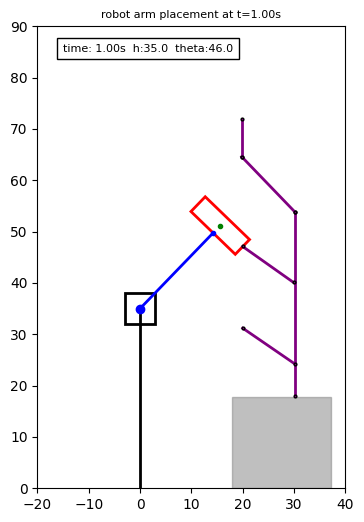

In [382]:
steps = 30
times = np.linspace(0,1,steps)
heights = np.linspace(40,35,steps)
angles = np.linspace(90,46,steps)
trajectory = {"time": times, "H": heights, "THETA": angles}

animate_trajectory(trajectory)